# Exercise 2

In [2]:
import numpy as np
import tqdm
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

In [3]:
def read_vocabulary_from_file (filename):
    with open(filename , 'r', encoding ="ISO−8859−1") as f:
        content = f. readlines () # content is a list of lines
        content = [x.strip() for x in content] # removing newline chars
        content = [x for x in content if x != '' and x[0] != ';' and x[-1] != '+']
        return content

In [4]:
positive_words = read_vocabulary_from_file('Data/positive-words.txt')
negative_words = read_vocabulary_from_file('Data/negative-words.txt')

**Compare with given lenght of exercise**

In [5]:
assert len(positive_words) == 2005
assert len(negative_words) == 4783

# Load Embeddings

In [7]:
def load_glove_embeddings (path):
    embeddings = {}
    with open(path , 'r', encoding ='utf−8') as f:
        for line in f:
            values = line.strip ().split ()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings [w] = vectors
        return embeddings

word_dict = load_glove_embeddings('Data/glove.6B.100d.txt')
def get_glove_embedding(query):
    # off−line dictionary
    word = query
    if word not in word_dict.keys():
        return None
    return word_dict[word] # if word is in word_dict


In [8]:
import requests
import json
def get_online_embeddings(query):
     # online query
    response = requests.get(f'https://icoservices.kube.isc.heia-fr.ch/word-embedding/wordvector/word2vec/en/{query}')
    vector = response.json()
    return vector

In [9]:
def prepare_strings_as_vectors(words, embedding_func = get_glove_embedding):
    response = []
    for i, word in tqdm.tqdm(enumerate(words)):
        
        embedding = embedding_func(words[i])
        if embedding is not None:
            response.append((word,embedding))
    return response

In [10]:
pos_words_emb = np.array(prepare_strings_as_vectors(positive_words), dtype=object)
neg_words_emb = np.array(prepare_strings_as_vectors(negative_words), dtype=object)

2005it [00:00, 276931.52it/s]
4783it [00:00, 699269.97it/s]


In [11]:
def get_response(words, default_response):
    return np.full((len(words), 2), default_response)

Y_positive = get_response(pos_words_emb, np.array([1,0]))
Y_negative = get_response(neg_words_emb, np.array([0,1]))

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_train_pos_words, X_test_pos_words, y_train_pos, y_test_pos = train_test_split(pos_words_emb, Y_positive, train_size=1500, random_state=42)

X_val_pos_words, X_test_pos_words, y_val_pos, y_test_pos = train_test_split(X_test_pos_words, y_test_pos, train_size=200, random_state=42)

X_train_neg_words, X_test_neg_words, y_train_neg, y_test_neg = train_test_split(neg_words_emb, Y_negative, train_size=1500, random_state=42)

X_val_neg_words, X_test_neg_words, y_val_neg, y_test_neg = train_test_split(X_test_neg_words, y_test_neg, train_size=200, random_state=42)

In [33]:
X_train = np.concatenate((X_train_pos_words[:, 1], X_train_neg_words[:, 1]))
X_val = np.concatenate((X_val_pos_words[:, 1], X_val_neg_words[:, 1]))

X_train = np.stack(X_train, axis=0)
X_val = np.stack(X_val, axis=0)

Y_train = np.concatenate((y_train_pos, y_train_neg))
Y_val = np.concatenate((y_val_pos, y_val_neg))

X_train, Y_train = shuffle(X_train, Y_train)
X_val, Y_val = shuffle(X_val, Y_val)



In [34]:
print(Y_val[:,0].sum())
print(Y_val[:,1].sum())
print(Y_val[:,0].sum() + Y_val[:,1].sum())
print(len(Y_val))

200
200
400
400


In [35]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(3000, 100)
(3000, 2)
(400, 100)
(400, 2)


In [36]:
from tensorflow.keras.layers import Dense, Dropout, Activation
def get_model():
    n_embeddings = X_train.shape[1]
    n_hidden = 50
    n_categories = 2
    model = keras.Sequential()
    model.add(Dense(n_embeddings, input_shape=(n_embeddings,), activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(n_categories, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.0002)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model
model = get_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 10,302
Trainable params: 10,302
Non-trainable params: 0
_________________________________________________________________


In [37]:
log = model.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=True, validation_data=(X_val, Y_val))

Epoch 1/15
15/94 [===>..........................] - ETA: 0s - loss: 0.7333 - accuracy: 0.5271

2022-05-09 17:55:53.843726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 1s 9ms/step - loss: 0.6381 - accuracy: 0.6290 - val_loss: 0.5238 - val_accuracy: 0.7400
Epoch 2/15
 8/94 [=>............................] - ETA: 0s - loss: 0.5313 - accuracy: 0.7617

2022-05-09 17:55:54.640316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 1s 8ms/step - loss: 0.4860 - accuracy: 0.7863 - val_loss: 0.4132 - val_accuracy: 0.8350
Epoch 3/15
94/94 [==============================] - 1s 8ms/step - loss: 0.4030 - accuracy: 0.8373 - val_loss: 0.3493 - val_accuracy: 0.8750
Epoch 4/15
94/94 [==============================] - 1s 8ms/step - loss: 0.3500 - accuracy: 0.8650 - val_loss: 0.3118 - val_accuracy: 0.8850
Epoch 5/15
94/94 [==============================] - 1s 8ms/step - loss: 0.3109 - accuracy: 0.8753 - val_loss: 0.2906 - val_accuracy: 0.8800
Epoch 6/15
94/94 [==============================] - 1s 8ms/step - loss: 0.2951 - accuracy: 0.8797 - val_loss: 0.2748 - val_accuracy: 0.8925
Epoch 7/15
94/94 [==============================] - 1s 8ms/step - loss: 0.2809 - accuracy: 0.8873 - val_loss: 0.2671 - val_accuracy: 0.8925
Epoch 8/15
94/94 [==============================] - 1s 8ms/step - loss: 0.2621 - accuracy: 0.8953 - val_loss: 0.2607 - val_accuracy: 0.8925
Epoch 9/15
94/94 [=============

In [38]:
# Add plotting function
def plot_loss_acc(log):
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(log.history['loss'], label='Training loss')
    ax1.plot(log.history['val_loss'], label='Val loss')
    ax1.legend()
    ax1.grid()
    ax2.plot(log.history['accuracy'], label='Training acc')
    ax2.plot(log.history['val_accuracy'], label='Val acc')
    ax2.legend()
    ax2.grid()

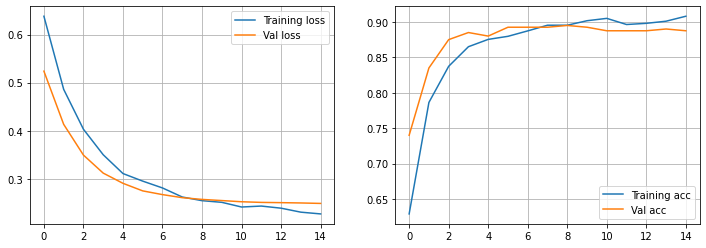

In [39]:
plot_loss_acc(log)

With all of my experiments, I had 

**Looks like the test accuracy is better than it should be according to the exercise!**

In [22]:
X_test = np.concatenate((X_test_pos_words, X_test_neg_words))

X_test_emb = np.stack(X_test[:,1], axis=0)
Y_test = np.concatenate((y_test_pos, y_test_neg))


result = model(X_test_emb)
pos = np.argpartition(result[:, 0].numpy(), -10)[-10:]
negs = np.argpartition(result[:, 1].numpy(), -10)[-10:]
print('**Words on unseen data**')
print('most positive words:')
print(X_test[pos][:,0])
print('most negative words:')
print(X_test[negs][:,0])

**Words on unseen data**
most positive words:
['celebrated' 'good' 'equitable' 'entertaining' 'honor' 'gracious'
 'vibrant' 'wonderful' 'courage' 'exciting']
most negative words:
['vomiting' 'cronyism' 'bloody' 'abusive' 'swollen' 'harassment' 'blame'
 'negligence' 'foul' 'bullying']


In [23]:
print('uncertein words')
print(', '.join(X_test[(0.6>result[:, 0]) & (result[:, 0]>0.4)][:,0]))

uncertein words
mesmerizes, ethical, glorify, toll-free, suffice, enticed, exalting, soundness, titillate, bewilderingly, kaput, strenuous, debase, mordantly, caustically, mashed, detract, divergent, subjugate, madly, deplete, slowest, fidget, betray, damn, desert, disadvantages, losing, fictional, wrest, regrets, appall, drop-out, deviousness, hothouse, disinterested, faltered, occluded, break, detriment, decadent, moody, fainthearted, feebleminded, vibrates, latency, stiflingly, mediocre, arduous, peculiarly, ironic, fails, woe, defensive, insouciance, unnaturally, craze, precariously, frazzle, inanely, imperiously, fatuously, lose, renunciation, plebeian, seriousness, prik


In [ ]:
›